In [1]:
!pip install xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from tqdm.notebook import tqdm
from sklearn import metrics
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable


In [2]:
df = pd.read_csv('parkinson_disease.csv')
pd.set_option('display.max_columns', 10)
df.sample(5)

,id,gender,PPE,DFA,RPDE,...,tqwt_kurtosisValue_dec_33,tqwt_kurtosisValue_dec_34,tqwt_kurtosisValue_dec_35,tqwt_kurtosisValue_dec_36,class
203,67,0,0.42874,0.62713,0.53534,...,3.0855,2.5670,3.9258,3.7013,1
253,84,0,0.85680,0.80533,0.46087,...,30.3080,25.0281,24.7547,68.6664,1
424,141,1,0.56693,0.78076,0.80600,...,2.5375,3.4493,3.4317,8.5358,1
733,244,0,0.80988,0.71329,0.42801,...,3.0519,2.7694,2.4828,2.8897,0
225,75,0,0.80262,0.80754,0.39255,...,2.6902,2.3387,2.3601,3.4241,0


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 756 entries, 0 to 755
Columns: 755 entries, id to class
dtypes: float64(749), int64(6)
memory usage: 4.4 MB


In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,756.0,125.500000,72.793721,0.000000,62.750000,125.500000,188.250000,251.00000
gender,756.0,0.515873,0.500079,0.000000,0.000000,1.000000,1.000000,1.00000
PPE,756.0,0.746284,0.169294,0.041551,0.762833,0.809655,0.834315,0.90766
DFA,756.0,0.700414,0.069718,0.543500,0.647053,0.700525,0.754985,0.85264
RPDE,756.0,0.489058,0.137442,0.154300,0.386537,0.484355,0.586515,0.87123
...,...,...,...,...,...,...,...,...
tqwt_kurtosisValue_dec_33,756.0,12.375335,16.341665,1.628700,3.114375,4.741450,12.201325,73.53220
tqwt_kurtosisValue_dec_34,756.0,14.799230,15.722502,1.861700,3.665925,6.725700,21.922050,62.00730
tqwt_kurtosisValue_dec_35,756.0,14.751559,14.432979,1.955900,3.741275,7.334250,22.495175,57.54430
tqwt_kurtosisValue_dec_36,756.0,31.481110,34.230991,2.364000,3.948750,10.637250,61.125325,156.42370


In [5]:
df.isnull().sum().sum()

0

In [8]:
columns = list(df.columns)
for col in columns:
    if col == 'class':
        continue

    filtered_columns = [col]
    for col1 in df.columns:
        if((col == col1) | (col == 'class')):
            continue

        val = df[col].corr(df[col1])
        if val > 0.7:
            # If the correlation between the two features is more than 0.7, remove it
            columns.remove(col1)
            continue
        else:
            filtered_columns.append(col1)
            
    df = df[filtered_columns]
df.shape

(252, 287)

In [9]:
X = df.drop('class', axis=1)
X_norm = MinMaxScaler().fit_transform(X)
selector = SelectKBest(chi2, k=30)
selector.fit(X_norm, df['class'])
filtered_columns = selector.get_support()
filtered_data = X.loc[:, filtered_columns]
filtered_data['class'] = df['class']
df = filtered_data
df.shape

(252, 31)

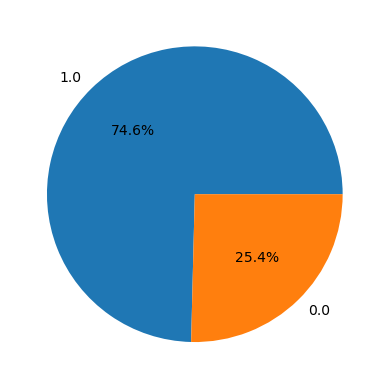

In [10]:
x = df['class'].value_counts()
plt.pie(x.values,
        labels = x.index,
        autopct='%1.1f%%')
plt.show()

In [11]:
features = df.drop('class', axis=1)
target = df['class']

X_train, X_val,Y_train, Y_val = train_test_split(features, target,
                                      test_size=0.2,
                                      random_state=10)

ros = RandomOverSampler(sampling_strategy=1.0,
                        random_state=0)
X, Y = ros.fit_resample(X_train, Y_train)
X.shape, Y.value_counts()

((302, 30),
 class
 1.0    151
 0.0    151
 Name: count, dtype: int64)

In [ ]:
from sklearn.metrics import roc_auc_score as ras

models = [LogisticRegression(class_weight='balanced'), XGBClassifier(), SVC(kernel='rbf', probability=True)] 
for model in models:
    model.fit(X_resampled, y_resampled)
    print(f'{model} : ')

    train_preds = model.predict(X_resampled)
    print('Training Accuracy : ', ras(y_resampled, train_preds))

    val_preds = model.predict(X_val)
    print('Validation Accuracy : ', ras(y_val, val_preds))
    print()